[*********************100%***********************]  1 of 1 completed

Getting data for Apple (AAPL)...
Getting data for Microsoft (MSFT)...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Getting data for Google (GOOGL)...



[*********************100%***********************]  1 of 1 completed


Getting data for Amazon (AMZN)...
Getting data for Tesla (TSLA)...


[*********************100%***********************]  1 of 1 completed


Analyzing Apple (AAPL)...


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

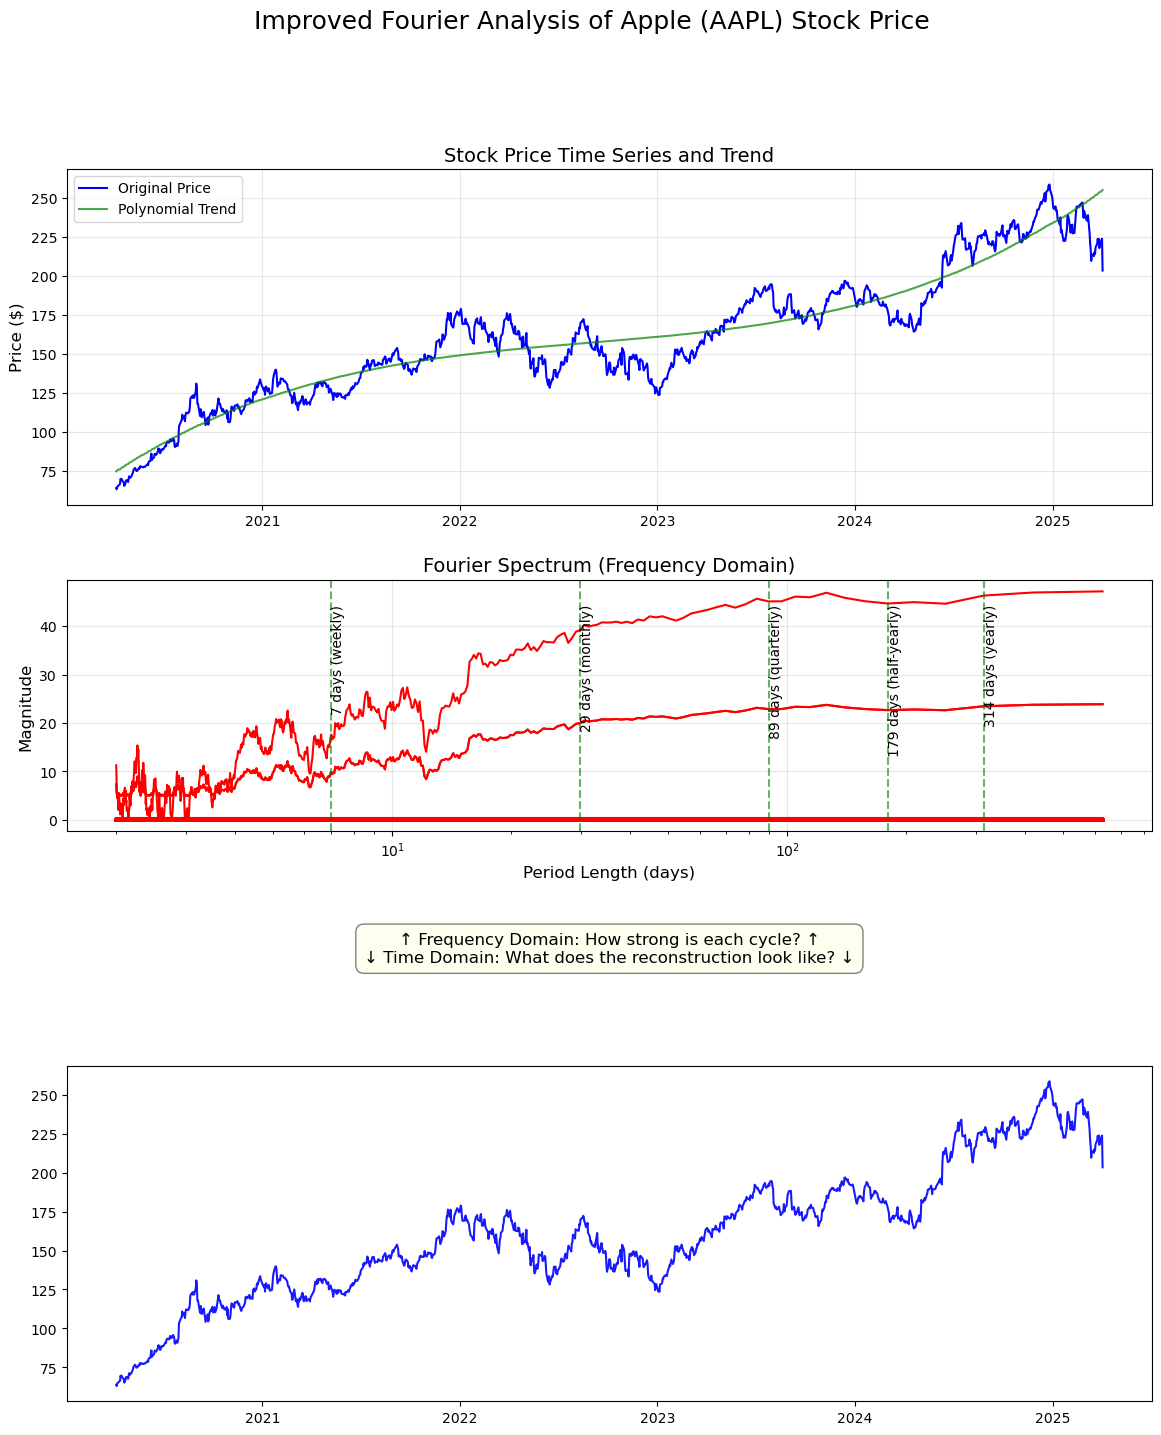

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.fft import fft, fftfreq, ifft
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from scipy import signal

# Define the companies to analyze
companies = {
    'AAPL': 'Apple',
    'MSFT': 'Microsoft',
    'GOOGL': 'Google',
    'AMZN': 'Amazon',
    'TSLA': 'Tesla'
}

# Function to get stock data
def get_stock_data(ticker, years=5):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*years)
    
    # Get daily closing prices
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']

# Function to compute and plot improved Fourier analysis with better reconstructions
def improved_fourier_analysis(ticker_data, company_name, ticker):
    # Remove NaN values and prepare data
    data = ticker_data.dropna()
    values = data.values
    dates = data.index
    
    # Calculate trend using polynomial fit - this will be added back later
    t = np.arange(len(values))
    trend_degree = 3  # Cubic trend
    trend_coeffs = np.polyfit(t, values, trend_degree)
    trend = np.polyval(trend_coeffs, t)
    
    # Detrend the data by subtracting the trend, not just the mean
    values_detrended = values - trend
    
    # Apply a window function to reduce spectral leakage
    window = signal.windows.hann(len(values_detrended))
    values_windowed = values_detrended * window
    
    # Compute FFT
    n = len(values_windowed)
    fft_values = fft(values_windowed)
    
    # 2-sided spectrum, take only the first half
    fft_magnitude = np.abs(fft_values[:n//2]) / n
    
    # Get the corresponding frequencies (in cycles per day)
    freqs = fftfreq(n)[:n//2]
    
    # Convert to periods (in days)
    periods = 1 / freqs[1:]  # Skip the DC component (first element)
    
    # Create a figure with GridSpec for better control
    fig = plt.figure(figsize=(14, 16))
    gs = GridSpec(4, 1, height_ratios=[2, 1.5, 0.5, 2], hspace=0.3)
    
    # Title for the entire figure
    fig.suptitle(f'Improved Fourier Analysis of {company_name} ({ticker}) Stock Price', fontsize=18, y=0.98)
    
    # 1. Original time series and trend
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(dates, values, 'b-', linewidth=1.5, label='Original Price')
    ax1.plot(dates, trend, 'g-', linewidth=1.5, alpha=0.7, label='Polynomial Trend')
    ax1.set_title('Stock Price Time Series and Trend', fontsize=14)
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.legend(loc='upper left')
    
    # Format date axis
    plt.setp(ax1.get_xticklabels(), rotation=0, ha='center')
    
    # 2. Fourier Spectrum with improved visualization
    ax2 = fig.add_subplot(gs[1])
    notable_periods = [7, 30, 90, 180, 365]  # 1 week, 1 month, quarterly, 6 months, yearly
    ax2.plot(periods[1:], fft_magnitude[2:], 'r-', linewidth=1.5)
    ax2.set_title('Fourier Spectrum (Frequency Domain)', fontsize=14)
    ax2.set_xlabel('Period Length (days)', fontsize=12)
    ax2.set_ylabel('Magnitude', fontsize=12)
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Add markers and annotations for notable periods
    for period in notable_periods:
        idx = np.argmin(np.abs(periods - period))
        if idx > 0:
            ax2.axvline(x=periods[idx], color='g', linestyle='--', alpha=0.6)
            label = f"{int(periods[idx])} days"
            if period == 7:
                label += " (weekly)"
            elif period == 30:
                label += " (monthly)" 
            elif period == 90:
                label += " (quarterly)"
            elif period == 180:
                label += " (half-yearly)"
            elif period == 365:
                label += " (yearly)"
            ax2.text(periods[idx], ax2.get_ylim()[1]*0.9, label, 
                    rotation=90, verticalalignment='top', fontsize=10)
    
    # 3. Connecting visualization to show the relationship between domains
    ax3 = fig.add_subplot(gs[2])
    ax3.text(0.5, 0.5, '↑ Frequency Domain: How strong is each cycle? ↑\n↓ Time Domain: What does the reconstruction look like? ↓', 
             horizontalalignment='center', verticalalignment='center', fontsize=12,
             bbox=dict(facecolor='lightyellow', alpha=0.5, boxstyle='round,pad=0.5'))
    ax3.axis('off')
    
    # 4. Improved reconstructions with different numbers of components + trend
    # Get magnitude of each frequency component
    fft_abs = np.abs(fft_values)
    
    # Get indices sorted by magnitude (most significant first)
    indices = np.argsort(fft_abs)[::-1]
    
    # Components to show in reconstructions
    num_comps_to_show = [1, 5, 20, 100]
    
    ax4 = fig.add_subplot(gs[3])
    ax4.plot(dates, values, 'b-', linewidth=1.5, label='Original', alpha=0.9)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(num_comps_to_show)))
    
    for i, num_c in enumerate(num_comps_to_show):
        # Create a filtered version of FFT values with only the top components
        filtered_fft = np.zeros_like(fft_values, dtype=complex)
        
        # Include the top N components
        for j in range(min(num_c, len(indices))):
            idx = int(indices[j])  # Ensure idx is a Python int
            filtered_fft[idx] = fft_values[idx]
    # Add the conjugate for real signals
            if idx > 0 and idx < n//2:
                filtered_fft[n-idx] = fft_values[n-idx]
        
        # Inverse FFT to get the oscillating components
        oscillations = np.real(ifft(filtered_fft))
        
        # Divide by window to correct amplitude of reconstructed signal
        # Avoid division by zero
        window_corrected = np.where(window > 0.1, window, 0.1)
        oscillations_corrected = oscillations / window_corrected
        
        # Add back the trend for complete reconstruction
        reconstructed = oscillations_corrected + trend
        
        # Plot reconstructed signal
        ax4.plot(dates, reconstructed, color=colors[i], linewidth=1.5, 
                 label=f'Top {num_c} components + trend', alpha=0.8)
    
    ax4.set_title('Original vs. Improved Reconstructions', fontsize=14)
    ax4.set_ylabel('Price ($)', fontsize=12)
    ax4.set_xlabel('Date', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.legend(loc='upper left')
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Add explanatory annotation
    textstr = '\n'.join([
        'Key improvements:',
        '1. Preserved trend using polynomial fit',
        '2. Applied windowing to reduce spectral leakage',
        '3. Selected components by true signal strength',
        '4. Added back trend to reconstructions'
    ])
    ax4.text(0.02, 0.02, textstr, transform=ax4.transAxes, fontsize=10,
             verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    return fig

# Main execution function
def main():
    all_data = {}
    
    print("Downloading stock data...")
    for ticker, name in companies.items():
        print(f"Getting data for {name} ({ticker})...")
        all_data[ticker] = get_stock_data(ticker)
    
    # Create a directory for saving plots
    output_dir = "improved_fourier_reconstruction_results"
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Run improved FFT analysis for each company
    for ticker, name in companies.items():
        print(f"Analyzing {name} ({ticker})...")
        
        # Improved FFT analysis
        fig = improved_fourier_analysis(all_data[ticker], name, ticker)
        fig.savefig(f"{output_dir}/{ticker}_improved_fourier_analysis.png", dpi=150, bbox_inches='tight')
        plt.close(fig)
    s
    print(f"Analysis complete! Results saved in the '{output_dir}' directory.")

if __name__ == "__main__":
    main()